# Preamble

In [1]:
#import packages

#%matplotlib widget

from sentropy import relative_sentropy

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
import random
from collections import Counter
from joblib import Parallel, delayed
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.feature import hog
from functools import partial
import os
from PIL import Image
from scipy.stats import linregress, norm
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import median as median_filter
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from statistics import NormalDist
import requests

# Loading images and reshuffling them

Note: the PathMNIST train dataset can also be downloaded from https://github.com/MedMNIST/MedMNIST/ and saved as 'pathmnist.npz'.

In [2]:
url = 'https://zenodo.org/records/6496656/files/pathmnist.npz?download=1'

r = requests.get(url, allow_redirects=True)

with open('pathmnist.npz', 'wb') as f:
    f.write(r.content)

In [3]:
#Path to data, make out-directory
path = "pathmnist.npz"
outdir = "pathology_outdir"

if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [4]:
data = np.load(path)

In [5]:
data.files

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [6]:
images = data['train_images']

In [7]:
Counter(list(data['train_labels'].flatten()))

Counter({np.uint8(8): 12885,
         np.uint8(5): 12182,
         np.uint8(3): 10401,
         np.uint8(2): 10360,
         np.uint8(1): 9509,
         np.uint8(7): 9401,
         np.uint8(0): 9366,
         np.uint8(4): 8006,
         np.uint8(6): 7886})

In [8]:
#Total number of images
n=len(images)
n

89996

In [9]:
#See the size of each image and if it's a color image
images[0].shape

(28, 28, 3)

Attention ! Re-running the following cell will change the order of images !

In [10]:
#Randomize the order of images in place
rng = np.random.default_rng(seed=49)   # deterministic
order = np.arange(n)
rng.shuffle(order)

In [11]:
shuffled_imgs = images[order]

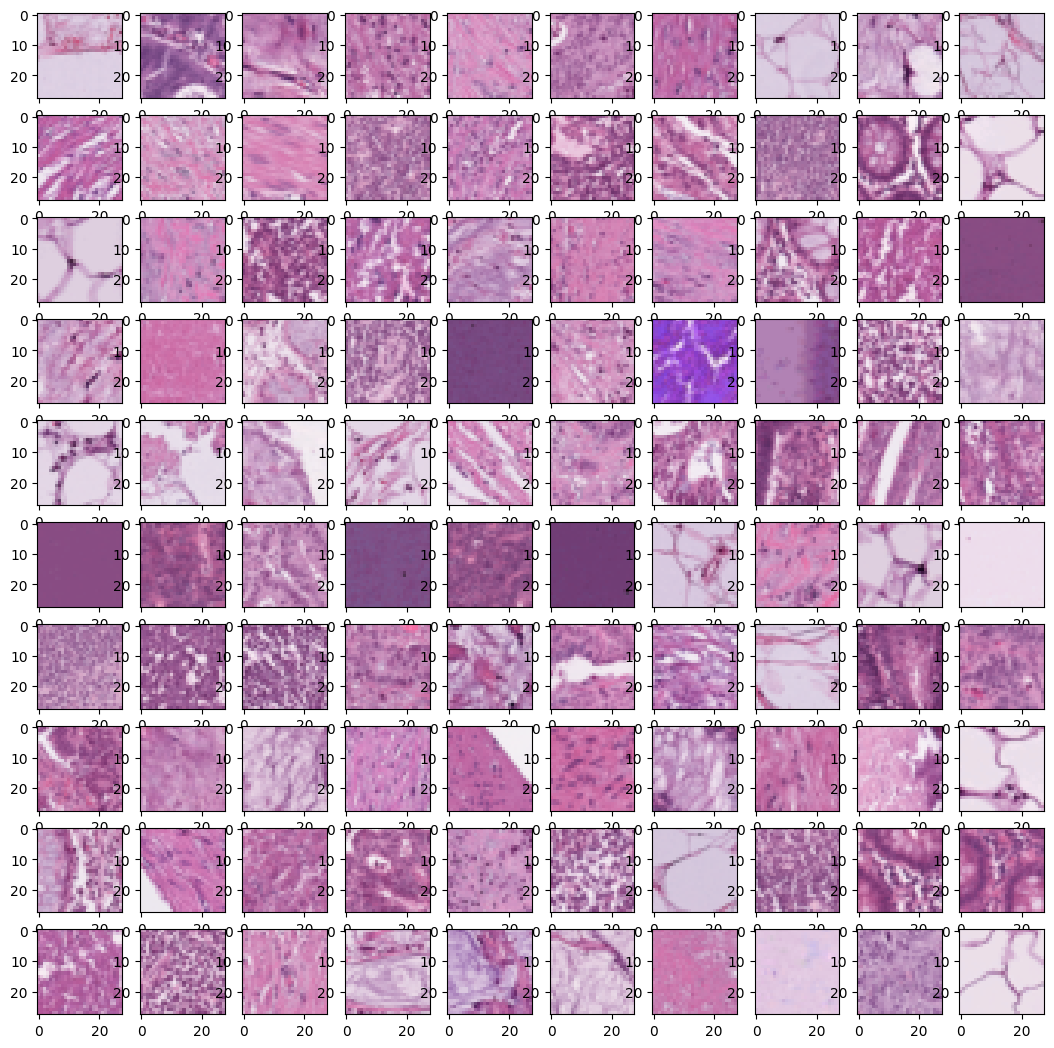

In [12]:
# Visualize the shuffled images
fig, axs = plt.subplots(ncols=10, nrows=10, figsize=(13,13))
for i in range(10):
   axs[0][i].imshow(shuffled_imgs[i])
for i in range(10):
   axs[1][i].imshow(shuffled_imgs[10+i])
for i in range(10):
   axs[2][i].imshow(shuffled_imgs[20+i])
for i in range(10):
   axs[3][i].imshow(shuffled_imgs[30+i])
for i in range(10):
   axs[4][i].imshow(shuffled_imgs[40+i])
for i in range(10):
   axs[5][i].imshow(shuffled_imgs[50+i])
for i in range(10):
   axs[6][i].imshow(shuffled_imgs[60+i])
for i in range(10):
   axs[7][i].imshow(shuffled_imgs[70+i])
for i in range(10):
   axs[8][i].imshow(shuffled_imgs[80+i])
for i in range(10):
   axs[9][i].imshow(shuffled_imgs[90+i])
plt.show()

# Preprocessing by thresholding the hue

In [13]:
hues_raw = np.array([rgb2hsv(img)[:,:,0] for img in shuffled_imgs])

In [14]:
hues_raw.shape

(89996, 28, 28)

In [15]:
reds = np.array([img[:,:,0] for img in shuffled_imgs])
greens = np.array([img[:,:,1] for img in shuffled_imgs])
blues = np.array([img[:,:,2] for img in shuffled_imgs])

In [16]:
reds.shape

(89996, 28, 28)

In [17]:
#Computing the lightnesses of all the images. 

lightnesses_raw = (1/2)*(1/255)*(np.maximum(np.maximum(reds, greens), blues).astype(float) + np.minimum(np.minimum(reds, greens), blues).astype(float))

In [18]:
lightnesses_raw.shape

(89996, 28, 28)

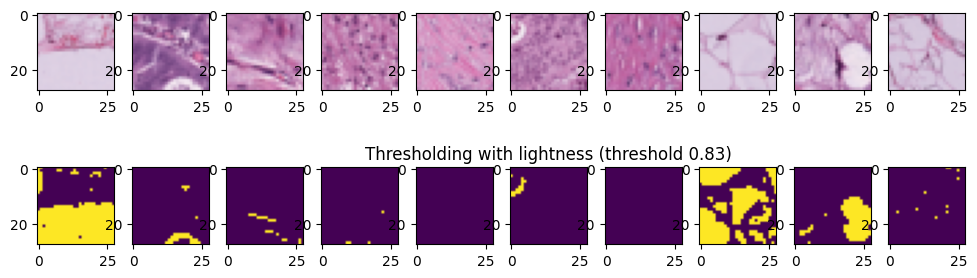

In [19]:
#Visualizing the threshold
def thresh(i):
    return lightnesses_raw[i] > 0.83

mask = np.array([thresh(i) for i in range(n)])
    
fig, axs = plt.subplots(ncols=10, nrows=2, figsize=(12,3))
plt.subplots_adjust(hspace=1)

for i in range(10):
    axs[0][i].imshow(shuffled_imgs[i])
    axs[1][i].imshow(thresh(i))

axs[1][5].set_title("Thresholding with lightness (threshold 0.83)")

plt.show()

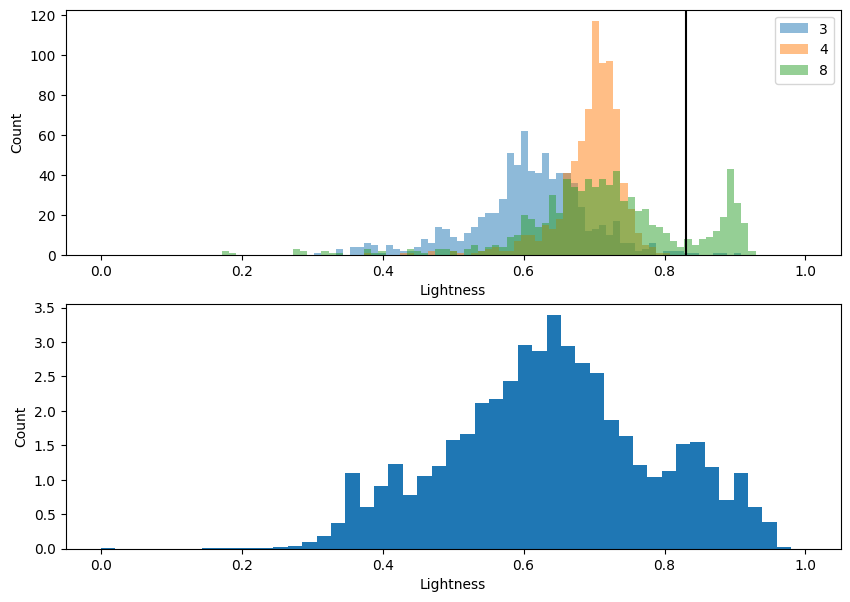

(np.float64(0.23529411764705882), np.float64(0.9549019607843137))

In [20]:
bins = np.linspace(0,1,100)

fig, axs = plt.subplots(2,1,figsize=(10,7))

axs[0].hist(lightnesses_raw[3].flatten(), label='3', alpha=0.5, bins=bins)
axs[0].hist(lightnesses_raw[4].flatten(), label='4', alpha=0.5, bins=bins)
axs[0].hist(lightnesses_raw[8].flatten(), label='8', alpha=0.5, bins=bins)
axs[0].axvline(0.83, color="black")
axs[0].set_xlabel("Lightness")
axs[0].set_ylabel("Count")
axs[0].legend()

axs[1].hist(lightnesses_raw.flatten(), bins=np.linspace(0,1,50), density=True)
axs[1].set_xlabel("Lightness")
axs[1].set_ylabel("Count")
plt.show()

np.percentile(lightnesses_raw, 0.1), np.percentile(lightnesses_raw, 99.9)

In [21]:
#Thresholding the hues.
hues = np.maximum(mask, hues_raw)

In [22]:
hues.shape

(89996, 28, 28)

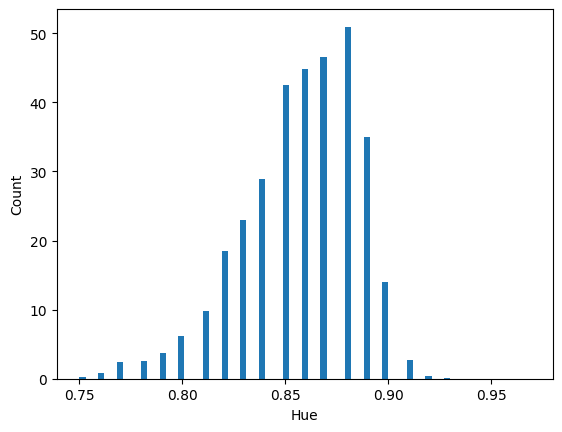

(np.float64(0.7522875816993464), np.float64(1.0))

In [23]:
plt.figure()
plt.hist(np.round(hues.flatten(),2), bins=np.arange(0.75,0.97,0.003) , density=True)
plt.xlabel("Hue")
plt.ylabel("Count")
plt.show()
np.percentile(hues, 0.1), np.percentile(hues, 99.9)

# Computing the hues and lightness histograms, for various superpixel sizes

In [24]:
#Hue histogram for the original image, with normalization
hue_hists = np.array([np.histogram(hues[i].ravel(), bins=np.linspace(0.75,1, 29))[0] for i in range(n)])
hue_hists =np.array([hist/np.sum(hist) for hist in hue_hists])

In [25]:
hue_hists.shape

(89996, 28)

In [26]:
#Hue channels after grouping pixels
hues_2 = hues.reshape(n, 14, 2, 14, 2).mean(axis=(2,4))
hues_4 = hues.reshape(n, 7, 4, 7, 4).mean(axis=(2,4))
hues_7 = hues.reshape(n, 4, 7, 4, 7).mean(axis=(2,4))
hues_14 = hues.reshape(n, 2, 14, 2, 14).mean(axis=(2,4))
hues_28 = hues.reshape(n, 1, 28, 1, 28).mean(axis=(2,4))

In [27]:
#Hue histograms for all the superpixel sizes

hue_hists_2 = np.array([np.histogram(hues_2[i].ravel(), bins=np.linspace(0.75, 1, 15))[0] for i in range(n)])

hue_hists_4 = np.array([np.histogram(hues_4[i].ravel(), bins=np.linspace(0.75, 1, 8))[0] for i in range(n)])

hue_hists_7 = np.array([np.histogram(hues_7[i].ravel(), bins=np.linspace(0.75, 1, 5))[0] for i in range(n)])

hue_hists_14 = np.array([np.histogram(hues_14[i].ravel(), bins=np.linspace(0.75, 1, 3))[0] for i in range(n)])

hue_hists_28 = np.array([np.histogram(hues_28[i].ravel(), bins=np.linspace(0.75, 1, 2))[0] for i in range(n)])

In [28]:
#Lightness histogram

lightness_raw_hists = np.array([np.histogram(lightnesses_raw[i].ravel(), bins=np.linspace(0.2, 1, 29))[0] for i in range(n)])
lightness_raw_hists =np.array([hist/np.sum(hist) for hist in lightness_raw_hists])

In [29]:
lightness_raw_hists.shape

(89996, 28)

# More preprocessing to eliminate bad images; normalizing the hue histograms

In [30]:
empty_hists = []

for i in range(n):
    if (np.sum(hue_hists_2[i]) == 0) or (np.sum(hue_hists_4[i]) == 0) or (np.sum(hue_hists_7[i]) == 0) or (np.sum(hue_hists_14[i]) == 0) or (np.sum(hue_hists_28[i]) == 0):
        empty_hists.append(i)

In [31]:
len(empty_hists)

30

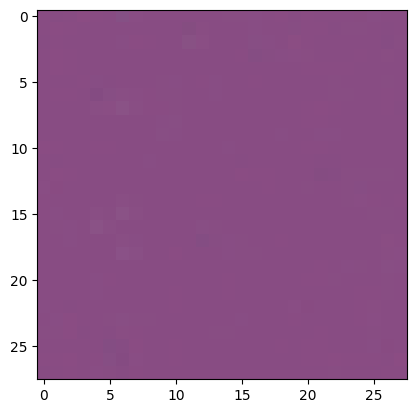

In [32]:
#Reference image that looks like a uniformly purple background
plt.imshow(shuffled_imgs[50])

In [33]:
uniform_dark_purple = []

for i in range(n):
    if (True in (hue_hists[i] > 0.5)) and np.sum(np.minimum(hue_hists[i], hue_hists[50])) > 0.4:
        uniform_dark_purple.append(i)

In [34]:
len(uniform_dark_purple)

1327

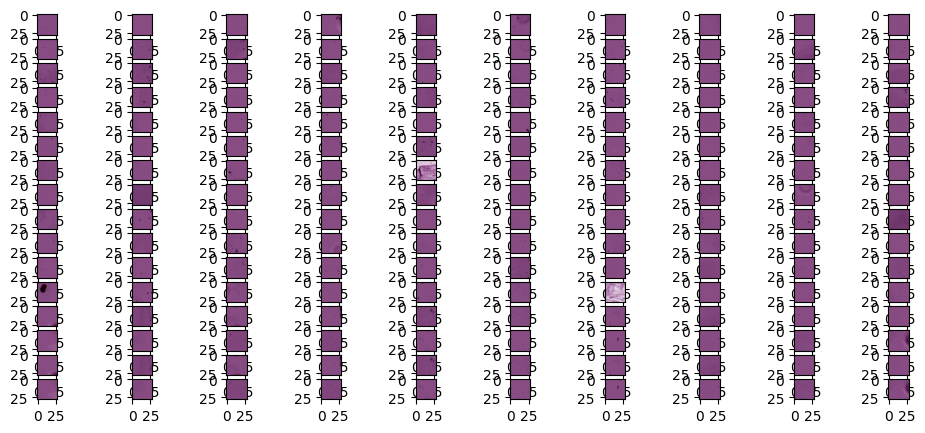

In [35]:
fig, axs = plt.subplots(16, 10, figsize=(12,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[uniform_dark_purple[i]])
    axs[1][i].imshow(shuffled_imgs[uniform_dark_purple[10+i]])
    axs[2][i].imshow(shuffled_imgs[uniform_dark_purple[20+i]])
    axs[3][i].imshow(shuffled_imgs[uniform_dark_purple[30+i]])
    axs[4][i].imshow(shuffled_imgs[uniform_dark_purple[40+i]])
    axs[5][i].imshow(shuffled_imgs[uniform_dark_purple[50+i]])
    axs[6][i].imshow(shuffled_imgs[uniform_dark_purple[60+i]])
    axs[7][i].imshow(shuffled_imgs[uniform_dark_purple[70+i]])
    axs[8][i].imshow(shuffled_imgs[uniform_dark_purple[80+i]])
    axs[9][i].imshow(shuffled_imgs[uniform_dark_purple[90+i]])
    axs[10][i].imshow(shuffled_imgs[uniform_dark_purple[100+i]])
    axs[11][i].imshow(shuffled_imgs[uniform_dark_purple[110+i]])
    axs[12][i].imshow(shuffled_imgs[uniform_dark_purple[120+i]])
    axs[13][i].imshow(shuffled_imgs[uniform_dark_purple[130+i]])
    axs[14][i].imshow(shuffled_imgs[uniform_dark_purple[120+i]])
    axs[15][i].imshow(shuffled_imgs[uniform_dark_purple[130+i]])
plt.show()

In [36]:
dark = []

for i in range(n):
    if np.max(lightnesses_raw[i]) < 0.5:
        dark.append(i)

In [37]:
len(dark)

5264

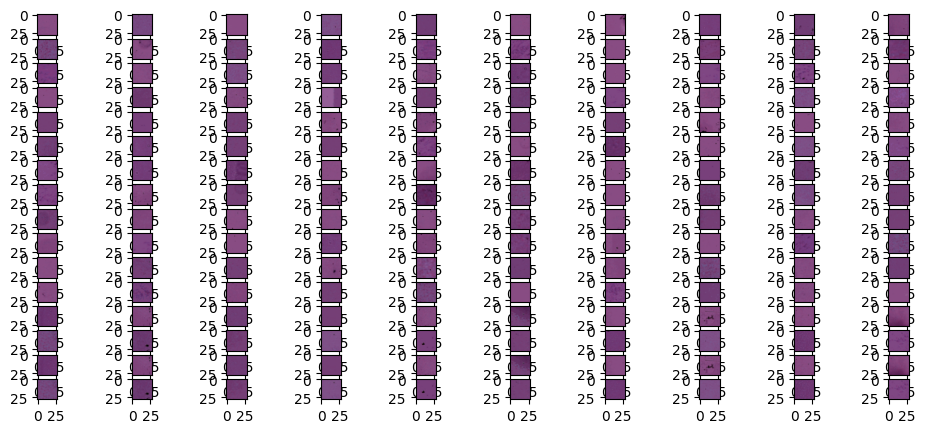

In [38]:
fig, axs = plt.subplots(16, 10, figsize=(12,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[dark[i]])
    axs[1][i].imshow(shuffled_imgs[dark[10+i]])
    axs[2][i].imshow(shuffled_imgs[dark[20+i]])
    axs[3][i].imshow(shuffled_imgs[dark[30+i]])
    axs[4][i].imshow(shuffled_imgs[dark[40+i]])
    axs[5][i].imshow(shuffled_imgs[dark[50+i]])
    axs[6][i].imshow(shuffled_imgs[dark[60+i]])
    axs[7][i].imshow(shuffled_imgs[dark[70+i]])
    axs[8][i].imshow(shuffled_imgs[dark[80+i]])
    axs[9][i].imshow(shuffled_imgs[dark[90+i]])
    axs[10][i].imshow(shuffled_imgs[dark[100+i]])
    axs[11][i].imshow(shuffled_imgs[dark[110+i]])
    axs[12][i].imshow(shuffled_imgs[dark[120+i]])
    axs[13][i].imshow(shuffled_imgs[dark[130+i]])
    axs[14][i].imshow(shuffled_imgs[dark[120+i]])
    axs[15][i].imshow(shuffled_imgs[dark[130+i]])
plt.show()

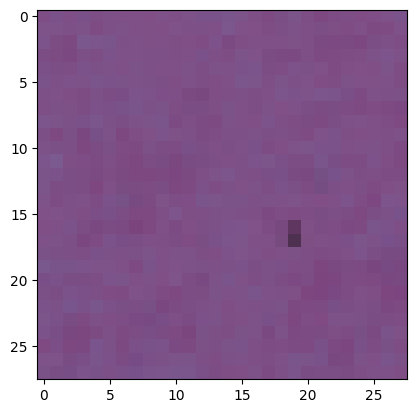

In [39]:
#Reference image that looks like a uniformly light pink background
plt.imshow(shuffled_imgs[53])

In [40]:
uniform_light_pink = []

for i in range(n):
    if np.sum(np.minimum(hue_hists[i], hue_hists[59])) > 0.9:
        uniform_light_pink.append(i)

In [41]:
len(uniform_light_pink)

1496

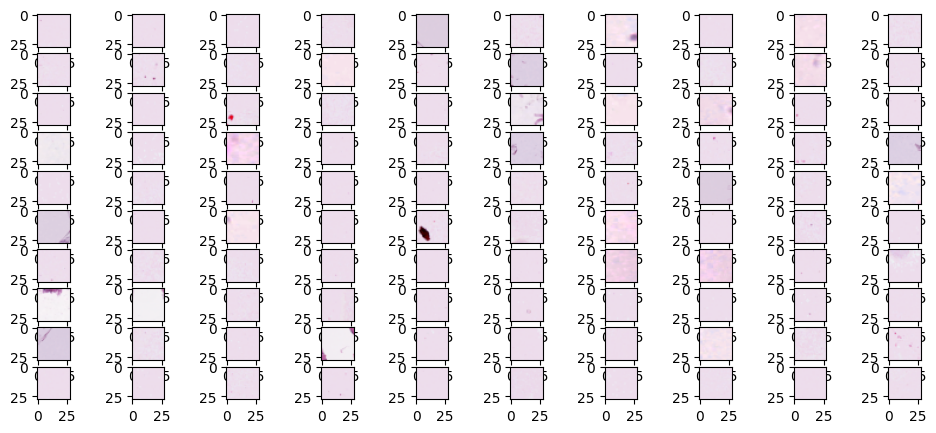

In [42]:
fig, axs = plt.subplots(10, 10, figsize=(12,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[uniform_light_pink[i]])
    axs[1][i].imshow(shuffled_imgs[uniform_light_pink[10+i]])
    axs[2][i].imshow(shuffled_imgs[uniform_light_pink[20+i]])
    axs[3][i].imshow(shuffled_imgs[uniform_light_pink[30+i]])
    axs[4][i].imshow(shuffled_imgs[uniform_light_pink[40+i]])
    axs[5][i].imshow(shuffled_imgs[uniform_light_pink[50+i]])
    axs[6][i].imshow(shuffled_imgs[uniform_light_pink[60+i]])
    axs[7][i].imshow(shuffled_imgs[uniform_light_pink[70+i]])
    axs[8][i].imshow(shuffled_imgs[uniform_light_pink[80+i]])
    axs[9][i].imshow(shuffled_imgs[uniform_light_pink[90+i]])

plt.show()

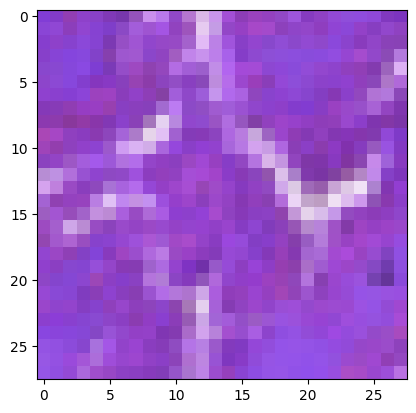

In [43]:
#Reference image that looks blue
plt.imshow(shuffled_imgs[36])

In [44]:
other_blues = []

for i in range(n):
    if np.sum(np.minimum(hue_hists[i], hue_hists[36])) > 0.5 and np.sum(hue_hists[i][10:20]) == 0:
        other_blues.append(i)

In [45]:
len(other_blues)

217

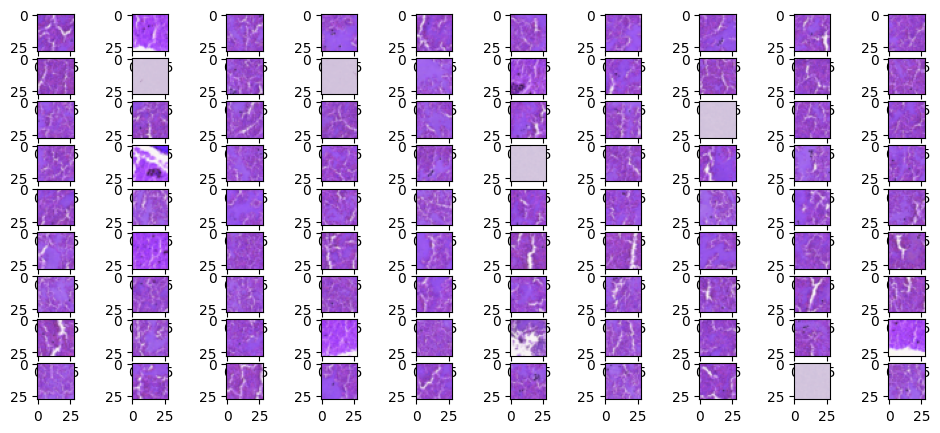

In [46]:
fig, axs = plt.subplots(9, 10, figsize=(12,5))
for i in range(10):
    axs[0][i].imshow(shuffled_imgs[other_blues[i]])
    axs[1][i].imshow(shuffled_imgs[other_blues[10+i]])
    axs[2][i].imshow(shuffled_imgs[other_blues[20+i]])
    axs[3][i].imshow(shuffled_imgs[other_blues[30+i]])
    axs[4][i].imshow(shuffled_imgs[other_blues[40+i]])
    axs[5][i].imshow(shuffled_imgs[other_blues[50+i]])
    axs[6][i].imshow(shuffled_imgs[other_blues[60+i]])
    axs[7][i].imshow(shuffled_imgs[other_blues[70+i]])
    axs[8][i].imshow(shuffled_imgs[other_blues[80+i]])
plt.show()

In [47]:
bad = list(set(empty_hists + uniform_dark_purple + dark + uniform_light_pink + other_blues))

In [48]:
len(bad)

7018

<div class="alert-danger">
Attention ! Some variables have been redefined in the following cell.
</div>

In [49]:
#Redefining several arrays of images and hues again to remove bad images.

shuffled_imgs = np.array([shuffled_imgs[i] for i in range(n) if i not in bad])
hues_raw = np.array([hues_raw[i] for i in range(n) if i not in bad])
lightnesses_raw = np.array([lightnesses_raw[i] for i in range(n) if i not in bad])

n = n - len(bad)

In [50]:
#Redoing the thresholding with a slightly lower threshold

new_mask = np.array([(lightnesses_raw[i] > 0.81) for i in range(n)])
hues = np.maximum(new_mask, hues_raw)
lightnesses = np.maximum(new_mask, lightnesses_raw)

In [51]:
print(n, hues.shape, lightnesses.shape)

82978 (82978, 28, 28) (82978, 28, 28)


In [52]:
#Remaking the hue histograms and normalizing them, now without the bad images.

hue_hists = np.array([np.histogram(hues[i].ravel(), bins=np.linspace(0.75, 1, 29))[0] for i in range(n)])
hue_hists = np.array([hist/np.sum(hist) for hist in hue_hists])

In [53]:
#Remaking the lightness histograms and normalizing them, now without the bad images.

lightness_hists = np.array([np.histogram(lightnesses[i].ravel(), bins=np.linspace(0.2, 1, 29))[0] for i in range(n)])
lightness_hists = np.array([hist/np.sum(hist) for hist in lightness_hists])

In [54]:
print(len(hue_hists), len(lightness_hists))

82978 82978


In [55]:
print(hue_hists[0].shape, lightness_hists[0].shape)

(28,) (28,)


# Hue and lightness similarities

In [56]:
def hue_sim_func(hue_1, hue_2):
    hue_hist_1 = np.histogram(hue_1.ravel(), bins=np.linspace(0.75, 1, 29))[0] 
    hue_hist_2 = np.histogram(hue_2.ravel(), bins=np.linspace(0.75, 1, 29))[0]

    hue_hist_1 = hue_hist_1/np.sum(hue_hist_1)
    hue_hist_2 = hue_hist_2/np.sum(hue_hist_2)

    return np.sum(np.minimum(hue_hist_1, hue_hist_2))

In [57]:
def lightness_sim_func(lightness_1, lightness_2):
    lightness_hist_1 = np.histogram(lightness_1.ravel(), bins=np.linspace(0.2, 1, 29))[0] 
    lightness_hist_2 = np.histogram(lightness_2.ravel(), bins=np.linspace(0.2, 1, 29))[0]

    lightness_hist_1 = lightness_hist_1/np.sum(lightness_hist_1)
    lightness_hist_2 = lightness_hist_2/np.sum(lightness_hist_2)

    return np.sum(np.minimum(lightness_hist_1, lightness_hist_2))

# Texture

In [58]:
def list_of_neis(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r-1,c), (r,c-1), (r,c+1), (r+1,c), 
             (r-1,c-1), (r-1,c+1), (r+1,c-1), (r+1,c+1),
            ]
    elif (r == 0) and (c == 0):
        neis = [
            (0,1), (1,0), 
                (1,1)
               ]
    elif (r == 0) and (c == n-1):
        neis = [
            (0,n-2), (1,n-2), 
                (1,n-1)
               ]
    elif (r == m-1) and (c == 0):
        neis = [
            (m-2, 0), (m-1,1),
               (m-2,1),
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
            (m-1,n-2), (m-2,n-1),
               (m-2,n-2),
               ]
    elif (r==0):
        neis = [
            (0, c-1), (1,c), (0,c+1),
               (1,c-1), (1,c+1),
               ]
    elif (r==m-1):
        neis = [
            (m-1,c-1), (m-2,c), (m-1,c+1),
               (m-2,c-1), (m-2,c+1),
               ]
    elif (c==0):
        neis = [
            (r-1, 0), (r,1), (r+1,0),
                (r-1,1), (r+1,1),
               ]
    elif (c==n-1):
        neis = [
            (r-1,n-1), (r,n-2), (r+1,n-1),
               (r-1,n-2), (r+1,n-2),
               ]
    return neis

In [59]:
def list_of_horizontal_neis(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r,c-1), (r,c+1),
            ]
    elif (r == 0) and (c == 0):
        neis = [
            (0,1),
               ]
    elif (r == 0) and (c == n-1):
        neis = [
            (0,n-2),
               ]
    elif (r == m-1) and (c == 0):
        neis = [
            (m-1,1),
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
            (m-1,n-2),
               ]
    elif (r==0):
        neis = [
            (0, c-1), (0,c+1),
               ]
    elif (r==m-1):
        neis = [
            (m-1,c-1), (m-1,c+1),
               ]
    elif (c==0):
        neis = [
            (r,1), 
               ]
    elif (c==n-1):
        neis = [
            (r,n-2), 
               ]
    return neis

In [60]:
def list_of_vertical_neis(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r-1,c), (r+1,c), 
            ]
    elif (r == 0) and (c == 0):
        neis = [
            (1,0), 
               ]
    elif (r == 0) and (c == n-1):
        neis = [
                (1,n-1),
               ]
    elif (r == m-1) and (c == 0):
        neis = [
            (m-2, 0),
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
            (m-2,n-1),
               ]
    elif (r==0):
        neis = [
            (1,c), 
               ]
    elif (r==m-1):
        neis = [
             (m-2,c),
               ]
    elif (c==0):
        neis = [
            (r-1, 0), (r+1,0),
               ]
    elif (c==n-1):
        neis = [
            (r-1,n-1), (r+1,n-1),
               ]
    return neis

In [61]:
def list_of_diagonal_neis_1(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r-1,c-1), (r+1,c+1), 
            ]
    elif (r == 0) and (c == 0):
        neis = [
            (1,1), 
               ]
    elif (r == 0) and (c == n-1):
        neis = [
               ]
    elif (r == m-1) and (c == 0):
        neis = [
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
            (m-2,n-2),
               ]
    elif (r==0):
        neis = [
            (1,c+1), 
               ]
    elif (r==m-1):
        neis = [
             (m-2,c-1),
               ]
    elif (c==0):
        neis = [
            (r+1,1),
               ]
    elif (c==n-1):
        neis = [
            (r-1,n-2)
               ]
    return neis

In [62]:
def list_of_diagonal_neis_2(r, c, m=28, n=28):
    if (r > 0) and (r < m-1) and (c > 0) and (c < n-1):
        neis = [
            (r-1,c+1), (r+1,c-1), 
            ]
    elif (r == 0) and (c == 0):
        neis = [
               ]
    elif (r == 0) and (c == n-1):
        neis = [
                (1,n-2),
               ]
    elif (r == m-1) and (c == 0):
        neis = [
                (m-2,1),
               ]
    elif (r == m-1) and (c == n-1):
        neis = [
               ]
    elif (r==0):
        neis = [
            (1,c-1), 
               ]
    elif (r==m-1):
        neis = [
             (m-2,c+1),
               ]
    elif (c==0):
        neis = [
            (r-1,1),
               ]
    elif (c==n-1):
        neis = [
            (r+1,n-2)
               ]
    return neis

In [63]:
def mottledness(img):
    gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(m):
        for c in range(n):
            neis = list_of_neis(r,c,m,n)
            diffs = [img[r,c] - img[nei] for nei in neis]
            max_abs_diff = np.max(np.absolute(np.array(diffs)))  # other options: np.median or np.mean
            gradients.append(max_abs_diff)

    gradients = np.array(gradients)
    
    return (np.sum(gradients)/(m*n))/0.39

In [64]:
mottlednesses = Parallel(n_jobs=-1)(delayed(lambda i : mottledness(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [65]:
len(mottlednesses)

82978

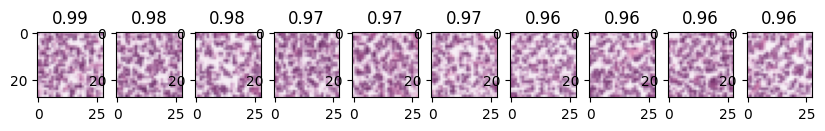

In [66]:
#Visualizing the 10 images with the highest mottlednesses

fig, ax = plt.subplots(1, 10, figsize=(10,100))
i=0
for img, mottledness in sorted(list(zip(shuffled_imgs, mottlednesses)), key = lambda x: x[1], reverse=True)[:10]:
    ax[i].imshow(img)
    ax[i].set_title(round(mottledness,2))
    i+=1

In [67]:
def h_stripedness(img):
    h_gradients = []
    v_gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(m):
        for c in range(n):
            h_neis = list_of_horizontal_neis(r,c,m,n)
            v_neis = list_of_vertical_neis(r,c,m,n)
            h_diffs = [img[r,c] - img[nei] for nei in h_neis]
            v_diffs = [img[r,c] - img[nei] for nei in v_neis]
            h_max_abs_diff = np.max(np.absolute(np.array(h_diffs)))
            v_max_abs_diff = np.max(np.absolute(np.array(v_diffs)))
            
            h_gradients.append(h_max_abs_diff)
            v_gradients.append(v_max_abs_diff)

    h_gradients = np.array(h_gradients)
    v_gradients = np.array(v_gradients)
    
    return ((1-np.sum(h_gradients)/(m*n))* np.sum(v_gradients/(m*n)))/0.229

In [68]:
def v_stripedness(img):
    h_gradients = []
    v_gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(m):
        for c in range(n):
            h_neis = list_of_horizontal_neis(r,c,m,n)
            v_neis = list_of_vertical_neis(r,c,m,n)
            h_diffs = [img[r,c] - img[nei] for nei in h_neis]
            v_diffs = [img[r,c] - img[nei] for nei in v_neis]
            h_max_abs_diff = np.max(np.absolute(np.array(h_diffs)))
            v_max_abs_diff = np.max(np.absolute(np.array(v_diffs)))
            
            h_gradients.append(h_max_abs_diff)
            v_gradients.append(v_max_abs_diff)

    h_gradients = np.array(h_gradients)
    v_gradients = np.array(v_gradients)
    
    return ((1-np.sum(v_gradients)/(m*n))* np.sum(h_gradients/(m*n)))/0.240

In [69]:
def d1_stripedness(img):
    d1_gradients = []
    d2_gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(1,m-1):
        for c in range(1,n-1):
            d1_neis = list_of_diagonal_neis_1(r,c,m,n)
            d2_neis = list_of_diagonal_neis_2(r,c,m,n)
            d1_diffs = [img[r,c] - img[nei] for nei in d1_neis]
            d2_diffs = [img[r,c] - img[nei] for nei in d2_neis]
            d1_max_abs_diff = np.max(np.absolute(np.array(d1_diffs)))
            d2_max_abs_diff = np.max(np.absolute(np.array(d2_diffs)))
            
            d1_gradients.append(d1_max_abs_diff)
            d2_gradients.append(d2_max_abs_diff)

    d1_gradients = np.array(d1_gradients)
    d2_gradients = np.array(d2_gradients)
    
    return ((1-np.sum(d2_gradients)/(m*n))* np.sum(d1_gradients/(m*n)))/(0.226)

In [70]:
def d2_stripedness(img):
    d2_gradients = []
    d1_gradients = []
    
    img = np.array(img)
    m, n = img.shape
    for r in range(1,m-1):
        for c in range(1,n-1):
            d2_neis = list_of_diagonal_neis_2(r,c,m,n)
            d1_neis = list_of_diagonal_neis_1(r,c,m,n)
            d2_diffs = [img[r,c] - img[nei] for nei in d2_neis]
            d1_diffs = [img[r,c] - img[nei] for nei in d1_neis]
            d2_max_abs_diff = np.max(np.absolute(np.array(d2_diffs)))
            d1_max_abs_diff = np.max(np.absolute(np.array(d1_diffs)))
            
            d2_gradients.append(d2_max_abs_diff)
            d1_gradients.append(d1_max_abs_diff)

    d2_gradients = np.array(d2_gradients)
    d1_gradients = np.array(d1_gradients)
    
    return ((1-np.sum(d1_gradients)/(m*n))* np.sum(d2_gradients/(m*n)))/0.215

In [71]:
def stripedness(img):
    return np.max([h_stripedness(img), v_stripedness(img), d1_stripedness(img), d2_stripedness(img)])

In [72]:
stripednesses = Parallel(n_jobs=-1)(delayed(lambda i : stripedness(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

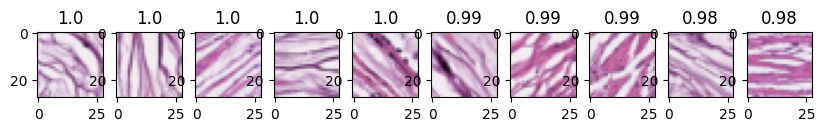

In [73]:
#Visualizing the 10 images with the highest stripednesses

fig, ax = plt.subplots(1, 10, figsize=(10,100))
i=0
for img, stripedness in sorted(list(zip(shuffled_imgs, stripednesses)), key = lambda x: x[1], reverse=True)[:10]:
    ax[i].imshow(img)
    ax[i].set_title(round(stripedness,2))
    i+=1

# Structure

In [74]:
default_threshold = 0.2

In [75]:
def median_filter_func(lightness):
    lightness = np.array(lightness)
    m,n = lightness.shape
    new_arr = np.zeros((m,n))
    
    for r in range(m):
        for c in range(n):
            neis_without_whites = []
            for nei in list_of_neis(r,c,m,n):
                if lightness[nei] < 1:
                    neis_without_whites.append(nei)

            if len(neis_without_whites) > 0:
                median = np.median(np.array([lightness[nei] for nei in neis_without_whites]))
            else:
                median = 1

            new_arr[r][c] = median
    return new_arr

In [76]:
def ConnectedComponents(g):
    n = len(g.keys())
    visited = {node: False for node in g.keys()}
   
    def dfs(current_node):
        if visited[current_node] == True:
            return
        else:
            visited[current_node] = True
        for nei in g[current_node]:
            dfs(nei)
           
    num = 0
    cumulative_connected_components = []
    
    for node in g.keys():
        if visited[node] == False:
            num += 1
            dfs(node)
            cumulative_connected_components.append([node for node in visited.keys() if visited[node] == True])

    connected_components = [cumulative_connected_components[0]]
    for i in range(1,len(cumulative_connected_components)):
        connected_components.append(list(set(cumulative_connected_components[i])-set(cumulative_connected_components[i-1])))
           
    return connected_components

In [77]:
def magic_wand(lightness, pixel, threshold=default_threshold, filter='median'):
    if filter=='median':
        lightness = median_filter_func(np.array(lightness))
    elif filter=='none':
        lightness = lightness
    else:
        lightness = gaussian_filter(np.array(lightness))

    m, n = lightness.shape

    max_value_below_1 = max([l for l in list(lightness.flatten()) if l < 1]) 
    lightness_range = max_value_below_1 - np.min(lightness)

    #lightness_range = np.max(lightness) - np.min(lightness)
    
    #Thresholding the image
    thresholded_lightness = 1 - (abs(lightness - lightness[pixel]) <= threshold*lightness_range)

    #Build adjacency matrix between dark pixels
    adj_mat = {}

    for i in range(m):
        for j in range(n):
            if thresholded_lightness[i][j] == 0:
                adj_mat[(i,j)] = []

    for (i,j) in adj_mat.keys():
        for nei in list_of_neis(i, j, m, n):
            if thresholded_lightness[nei] == 0:
                adj_mat[(i,j)].append(nei)

    components = ConnectedComponents(adj_mat)

    new_arr = np.ones((m,n))

    for component in components:
        if pixel in component:
            for other_pixel in component:
                new_arr[other_pixel] = 0

    #component = sorted(components, key=lambda x: len(x))[-1]
    #for pix in component:
        #new_arr[pix] = 0

    return new_arr

In [78]:
#This function counts the number of holes in a binary array, with the holes being white.

def number_of_holes(binary_array):
    binary_array = np.array(binary_array)
    m, n = binary_array.shape
    
    #Build adjacency matrix between dark pixels
    adj_mat = {}

    for i in range(m):
        for j in range(n):
            if binary_array[i][j] == 1:
                adj_mat[(i,j)] = []

    for (i,j) in adj_mat.keys():
        for nei in list_of_neis(i, j, m, n):
            if binary_array[nei] == 1:
                adj_mat[(i,j)].append(nei)

    if len(list(adj_mat.keys())) > 0:
        components = ConnectedComponents(adj_mat)
        #if a component is just a single pixel, we don't count that as a hole
        components_larger_than_single_pixel = []
        for component in components:
            if len(component) > 1:
                components_larger_than_single_pixel.append(component)
        
        return len(components_larger_than_single_pixel)

    else:
        return 0

In [79]:
lightness_first_filters = Parallel(n_jobs=-1)(delayed(lambda i : (np.sum(median_filter_func(lightnesses[i]).flatten() > 0.8)/(28*28)) > 0.5)(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [80]:
print(len(lightness_first_filters), lightness_first_filters[0])

82978 False


In [81]:
lightness_second_filters = Parallel(n_jobs=-1)(delayed(lambda i : (np.sum(median_filter_func(lightnesses[i]).flatten() > 0.8)/(28*28)) > 0.6)(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [82]:
print(len(lightness_second_filters), lightness_second_filters[0])

82978 False


In [83]:
darkest_values = Parallel(n_jobs=-1)(delayed(lambda i : np.min(median_filter_func(lightnesses[i])))(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [84]:
print(len(darkest_values), darkest_values[0])

82978 0.5843137254901961


In [85]:
def darkest_pixel_func(lightness):
    lightness = median_filter_func(lightness)
    pix = np.where(lightness == np.min(lightness))
    pix = (pix[0][0], pix[1][0])
    return pix

darkest_pixels = Parallel(n_jobs=-1)(delayed(lambda i : darkest_pixel_func(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [86]:
print(len(darkest_pixels), darkest_pixels[0])

82978 (np.int64(13), np.int64(10))


In [87]:
def structure_size_func(lightness):
    lightness = median_filter_func(lightness)
    pix = np.where(lightness == np.min(lightness))
    pix = (pix[0][0], pix[1][0])
    binary = magic_wand(lightness, pix, threshold=default_threshold)
    structure_size = np.sum(1 - binary)/(28*28)
    return structure_size

structure_sizes = Parallel(n_jobs=-1)(delayed(lambda i : structure_size_func(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [88]:
print(len(structure_sizes), structure_sizes[0])

82978 0.19770408163265307


In [89]:
lightness_ranges = Parallel(n_jobs=-1)(delayed(lambda i : np.max(median_filter_func(lightnesses[i])) - np.min(median_filter_func(lightnesses[i])))(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [90]:
print(len(lightness_ranges), lightness_ranges[0])

82978 0.4156862745098039


In [91]:
def restricted_lightness_range_func(lightness):
    lightness = median_filter_func(lightness)
    max_value_below_1 = max([l for l in list(lightness.flatten()) if l < 1]) 
    return max_value_below_1 - np.min(lightness)

restricted_lightness_ranges = Parallel(n_jobs=-1)(delayed(lambda i : restricted_lightness_range_func(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [92]:
print(len(restricted_lightness_ranges), restricted_lightness_ranges[0])

82978 0.22549019607843135


In [93]:
def n_of_holes_func(lightness):
    lightness = median_filter_func(lightness)
    pix = np.where(lightness == np.min(lightness))
    pix = (pix[0][0], pix[1][0])
    binary = magic_wand(lightness, pix, threshold=default_threshold)
    return number_of_holes(binary)

ns_of_holes = Parallel(n_jobs=-1)(delayed(lambda i : n_of_holes_func(lightnesses[i]))(i) for i in tqdm(range(n)))

  0%|          | 0/82978 [00:00<?, ?it/s]

In [94]:
print(len(ns_of_holes), ns_of_holes[0])

82978 3


# Preparing the numpy array to be passed to the X argument of Metacommunity later

In [95]:
old_Xs = list(zip(hue_hists, lightness_hists, mottlednesses, stripednesses, lightness_first_filters, lightness_second_filters, darkest_values, structure_sizes, lightness_ranges, restricted_lightness_ranges, ns_of_holes))

In [96]:
Xs = []

for old_X in tqdm(old_Xs):
    X = list(old_X[0]) + list(old_X[1]) + list(old_X[2:])
    Xs.append(X)

Xs = np.array(Xs)

  0%|          | 0/82978 [00:00<?, ?it/s]

In [97]:
Xs.shape

(82978, 65)

In [98]:
mini_Xs = Xs[:10000]

In [99]:
mini_Xs.shape

(10000, 65)

In [100]:
mini_Xs_dict= {i : Xs[i*10000: (i+1)*10000] for i in range(8)}
mini_Xs_dict[8] = Xs[500:10500]
mini_Xs_dict[9] = np.concatenate((Xs[:4000], Xs[-6000:]))
mini_Xs_dict[10] = np.concatenate((Xs[40000:45000], Xs[70000:75000]))

The similarity function:

In [101]:
def sim_func_modified(X_1, X_2):
    hue_hist_1, lightness_hist_1 = X_1[:28], X_1[28:56]
    mottledness_1, stripedness_1 = X_1[2+54], X_1[3+54]
    lightness_first_filter_1, lightness_second_filter_1 = X_1[4+54], X_1[5+54]
    darkest_value_1 = X_1[6+54]
    structure_size_1 = X_1[7+54]
    lightness_range_1, restricted_lightness_range_1 = X_1[8+54], X_1[9+54]
    n_of_holes_1 = X_1[10+54]

    hue_hist_2, lightness_hist_2 = X_2[:28], X_2[28:56]
    mottledness_2, stripedness_2 = X_2[2+54], X_2[3+54]
    lightness_first_filter_2, lightness_second_filter_2 = X_2[4+54], X_2[5+54]
    darkest_value_2 = X_2[6+54]
    structure_size_2 = X_2[7+54]
    lightness_range_2, restricted_lightness_range_2 = X_2[8+54], X_2[9+54]
    n_of_holes_2 = X_2[10+54]

    #Hue similarity
    hue_sim = np.sum(np.minimum(hue_hist_1, hue_hist_2))
    #Lightness similarity
    lightness_sim = np.sum(np.minimum(lightness_hist_1, lightness_hist_2))

    #Texture similarity
    if (mottledness_1 > 0.5 and mottledness_2 < 0.5) or (mottledness_1 < 0.5 and mottledness_2 > 0.5):
        mottledness_sim = 0.1
    else:
        mottledness_sim = (1 - abs(mottledness_1 - mottledness_2))

    if (stripedness_1 > 0.5 and stripedness_2 < 0.5) or (stripedness_1 < 0.5 and stripedness_2 > 0.5):
        stripedness_sim = 0.1
    else:
        stripedness_sim = (1 - abs(stripedness_1 - stripedness_2))

    texture_sim = np.min([mottledness_sim, stripedness_sim])

    #Structure similarity
    if lightness_first_filter_1 and lightness_first_filter_2:
        structure_size_sim = 0.9
    elif lightness_second_filter_1 or lightness_second_filter_2:
        structure_size_sim = 0.1

    else:

        structure_sizes_ratio = min(structure_size_1, structure_size_2)/max(structure_size_1, structure_size_2)
    
        if darkest_value_1 <= darkest_value_2:
            restricted_lightness_range_ref = restricted_lightness_range_1
            structure_size_ref = structure_size_1
        else:
            restricted_lightness_range_ref = restricted_lightness_range_2
            structure_size_ref = structure_size_2
    
        if abs(darkest_value_1 - darkest_value_2) <= default_threshold*restricted_lightness_range_ref:
            if (lightness_range_1 < 0.5 or lightness_range_2 < 0.5):
                structure_size_sim = None
            elif (structure_size_1 < 30/(28*28) and structure_size_2 < 30/(28*28)):
                structure_size_sim = None
            else:
                structure_size_sim = structure_sizes_ratio
        else:
            if structure_size_ref < 30/(28*28):
                structure_size_sim = None
            else:
                structure_size_sim = 0

    if max(n_of_holes_1, n_of_holes_2) > 0:
        hole_sim = min(n_of_holes_1, n_of_holes_2)/max(n_of_holes_1, n_of_holes_2)
    else:
        hole_sim = 1

    if structure_size_sim is None:
        return np.min([hue_sim, lightness_sim, texture_sim, hole_sim])
    else:
        return np.min([hue_sim, lightness_sim, texture_sim, structure_size_sim, hole_sim])

In [102]:
sim_func_modified(Xs[10], Xs[101])

np.float64(0.1)

# Computing the diversity

In [103]:
#Building the counts dataframe for the entire dataset.

counts = pd.DataFrame()

def starting_index(i):
    start = 0
    for j in range(1,i+1):
        start += 2**j
    return start

def ending_index(i):
    return starting_index(i) + 2**(i+1) 

for j in range(15):
    counts[j] = [0 for k in range(starting_index(j))] + [1 for k in range(starting_index(j),ending_index(j))] + [0 for k in range(ending_index(j),n)]

counts[15] = [0 for k in range(starting_index(15))] + [1 for k in range(starting_index(15),n)]

In [104]:
counts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82973,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
82974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
82975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
82976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [105]:
mini_counts = counts.iloc[:10000,:13]
mini_counts

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,0,0,1
9996,0,0,0,0,0,0,0,0,0,0,0,0,1
9997,0,0,0,0,0,0,0,0,0,0,0,0,1
9998,0,0,0,0,0,0,0,0,0,0,0,0,1


In [106]:
rel_subcomm_sizes = pd.Series([counts.sum(axis=0)[i]/n for i in range(counts.shape[1])])

In [107]:
mini_rel_subcomm_sizes = pd.Series([mini_counts.sum(axis=0)[i]/n for i in range(mini_counts.shape[1])])
mini_abs_subcomm_sizes = [mini_counts.sum(axis=0)[i] for i in range(mini_counts.shape[1])]

In [108]:
%%timeit

sim_func_modified(mini_Xs[11], mini_Xs[47])

7 μs ± 182 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [109]:
sim_func_modified(mini_Xs[1], mini_Xs[2])

np.float64(0.24234693877551022)

In [110]:
dfs = {i: pd.DataFrame() for i in range(10)}

for i in tqdm(range(10)):
    df = relative_sentropy(mini_counts, viewpoint=[0,1,np.inf], similarity=sim_func_modified, X=mini_Xs_dict[i], parallelize=True, \
                           symmetric=True, return_dataframe=True)
    df.to_csv(outdir + '/PathMNIST_Round' + str(i) + '.csv')
    dfs[i] = df

  0%|          | 0/10 [00:00<?, ?it/s]

2025-12-03 15:45:47,427	INFO worker.py:2012 -- Started a local Ray instance.
/Users/arnaoutlab/Desktop/sentropy/sentropy-venv/lib/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
(pid=gcs_server) [2025-12-03 15:46:17,104 E 10812 346272] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(weighted_similarity_chunk_symmetric pid=10826) [2025-12-03 15:46:18,878 E 10826 347218] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Runni

In [111]:
dfs[0]

,set/subset,viewpoint,alpha,rho,beta,gamma,normalized_alpha,normalized_rho,normalized_beta,rho_hat,beta_hat
0,set,0.0,95.334032,10.608293,0.256697,10.981437,10.365108,0.994012,1.007594,0.800691,0.194755
1,0,0.0,10000.000000,1057.531725,0.000946,9.610223,2.000000,0.211506,4.727991,88.044310,-0.082309
2,1,0.0,4297.323040,951.785202,0.001051,4.608134,1.718929,0.380714,2.626643,79.232100,-0.082195
3,2,0.0,4586.926494,726.155485,0.001377,6.552030,3.669541,0.580924,1.721394,60.429624,-0.081841
4,3,0.0,3037.858769,443.027976,0.002257,7.314267,4.860574,0.708845,1.410746,36.835665,-0.080888
5,4,0.0,2561.505231,278.409430,0.003592,10.144645,8.196817,0.890910,1.122448,23.117452,-0.079442
6,5,0.0,1063.624878,141.714639,0.007056,7.594246,6.807199,0.906974,1.102568,11.726220,-0.075689
7,6,0.0,652.736692,75.777155,0.013197,8.837912,8.355030,0.969948,1.030984,6.231430,-0.069037
8,7,0.0,376.335551,38.876152,0.025723,10.298910,9.634190,0.995229,1.004793,3.156346,-0.055467
9,8,0.0,171.532724,19.119055,0.052304,9.090780,8.782475,0.978896,1.021559,1.509921,-0.026671


In [112]:
dfs = {i: pd.DataFrame() for i in range(10)}

for i in range(10):
    dfs[i] = pd.read_csv(outdir + "/PathMNIST_Round" + str(i) + '.csv')

In [113]:
rho_bar = pd.DataFrame()

for i in range(10):
    df = dfs[i]
    rho_bar[i+1] = df[df['viewpoint']==0]['normalized_rho'][1:]

In [114]:
rho_bar

,1,2,3,4,5,6,7,8,9,10
1,0.211506,0.215193,0.270498,0.228067,0.292552,0.270865,0.268398,0.226688,0.267205,0.213836
2,0.380714,0.413480,0.461357,0.460604,0.500631,0.410937,0.295060,0.408269,0.401848,0.381404
3,0.580924,0.546958,0.614421,0.521771,0.535559,0.521916,0.529368,0.566644,0.529814,0.583550
4,0.708845,0.746519,0.734740,0.702688,0.686141,0.730206,0.775369,0.828310,0.695843,0.709238
5,0.890910,0.929922,0.815744,0.823231,0.802716,0.809868,0.871526,0.769429,0.830686,0.894996
6,0.906974,0.938699,0.916202,0.966849,0.908821,0.875985,0.885925,0.968352,0.905919,0.912387
7,0.969948,0.961726,0.989951,0.925202,0.923934,0.946104,0.974792,1.011604,0.981976,0.973264
8,0.995229,0.980717,0.956805,0.962492,0.998454,0.971539,0.963860,0.997157,0.954787,1.000034
9,0.978896,1.009147,1.000327,1.002722,0.966969,0.979087,0.973997,0.981997,0.991665,0.983368
10,0.997727,0.990044,0.991927,0.994903,0.997709,0.984174,1.001314,0.981861,0.984085,1.001995


In [115]:
mean_rho_bar = rho_bar.mean(axis=1)
std_rho_bar = rho_bar.std(axis=1)
mini_rel_subcomm_sizes_sorted, mini_abs_subcomm_sizes_sorted, mean_rho_bar_sorted, std_rho_bar_sorted = zip(*sorted(list(zip(mini_rel_subcomm_sizes, mini_abs_subcomm_sizes, mean_rho_bar, std_rho_bar))))

In [116]:
mini_abs_subcomm_sizes_sorted_simplified = list(mini_abs_subcomm_sizes_sorted)
mini_abs_subcomm_sizes_sorted_simplified[-3] = ''

/var/folders/q4/nf5g22ld5g19450bqyhntkpc0000gq/T/ipykernel_10573/879152532.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(x=x, y=y, yerr=E, ecolor="black", capsize=3, color="black", fmt="ko", ls=":", lw=0.5)


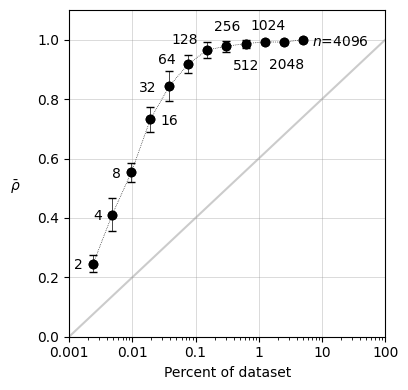

In [117]:
fig = plt.figure(figsize=(4.2, 4))

# a1 = fig.add_axes([0,0,1,1])
# a2 = a1.twiny()
x_offsets = [ 2,     2,     2,     0.7,   3,     3,     3.7,  1.6,   1.6,   1.7,   1.7,    0.7 ]
y_offsets = [-0.02, -0.02, -0.02, -0.02, -0.02, -0.0,  0.02,  0.05, -0.09,  0.04, -0.09,  -0.02]
#            2       4      8      16     32     64     128    256   512    1024   2048    4096 

ixs = np.r_[0:10, 11:13]
x   = np.array(mini_rel_subcomm_sizes_sorted)[ixs]
y   = np.array(mean_rho_bar_sorted)[ixs]
s   = np.array(mini_abs_subcomm_sizes_sorted_simplified)[ixs]

mini_abs_subcomm_sizes_sorted = 2**np.arange(1, len(mean_rho_bar_sorted)+1)/n

E = np.array(std_rho_bar_sorted)[ixs]

# data
plt.scatter(x=x, y=y, c="black")
for x_i, y_i, s_i, x_offset, y_offset in zip(x, y, s, x_offsets, y_offsets):
    if s_i == "4096": 
        plt.text(x_i/x_offset, y_i+y_offset, f"$n$={s_i}", c="black")
    else: 
        plt.text(x_i/x_offset, y_i+y_offset, s_i, c="black")
# a1.errorbar(x=mini_abs_subcomm_sizes_sorted[ixs][:-1], y=y[:-1], yerr=E[:-1], ecolor="black", capsize=3, 
#             color="black", fmt="ko", ls=":", lw=0.5)
plt.errorbar(x=x, y=y, yerr=E, ecolor="black", capsize=3, color="black", fmt="ko", ls=":", lw=0.5)

# y=x line
plt.plot([0.00001,1], [0.00001,1], zorder=-1000, c="#999", alpha=0.5)

# cosmetics
plt.xscale('log')
plt.grid(zorder=-1000, lw=0.5, color="#999", alpha=0.5)
plt.xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0], [0.001, 0.01, 0.1, 1, 10, 100])
plt.xlabel(r'Percent of dataset')
plt.ylabel(r'$\bar{\rho}$', rotation="horizontal")
ax = plt.gca()
ax.yaxis.set_label_coords(-0.17, .43)
plt.ylim(0, 1.1)
plt.xlim(1e-5, 1e0)
plt.tight_layout()

plt.savefig(outdir + "/pathology_fig8c.pdf")
plt.show()

In [118]:
# Find that n=512 is the smallest sample size that contains ≥95% of the diversity of the full dataset
print("256: ", y[7] - 2*E[7])
print("512: ", y[8] - 2*E[8])
print("1024:", y[9] - 2*E[9])

256:  0.9413181425348809
512:  0.9595447405024288
1024: 0.9778508799736805


In [119]:
# p-value
z = NormalDist(mu=y[8], sigma=E[8]).zscore(0.95)
norm.sf(z)

np.float64(0.9965324983515932)